<a id='notebook-top'></a>
This notebook plots the intensity and Doppler shift maps of the east and west upflow region in Fe XII 19.51 nm and Ne VIII 77.04 lines, observed by Hinode/EIS and SolO/SPICE, respectively. The east region (outlined by the purple contour) is defined by blueshifts greater than - 5 km/s in the Fe XII 19.51 nm line. The west region, also defined with blueshifts greater than -5 km/s is illustrated by the green contour. You may also see how these regions are defined throughout the notebook.
Link to [Figure 3](#figure-3).

Note: The internal hyperlink only works on [GitHub Pages](https://yjzhu-solar.github.io/EIS_DKIST_SolO/eis_eui_upflow_ipynb_html/eis_spice_doppler.html) or [nbviewer](https://nbviewer.org/github/yjzhu-solar/EIS_DKIST_SolO/blob/master/ipynb/ms_eis_eui_upflow/eis_spice_doppler.ipynb). Do not click when viewing the notebook on GitHub.

In [1]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface,
                               get_horizons_coord)
import pandas as pd
import os
import astropy
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.constants as const
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
from scipy.interpolate import LinearNDInterpolator
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc_context, rcParams
import matplotlib.patheffects as path_effects
import cmcrameri.cm as cmcm
from fancy_colorbar import plot_colorbar
import re
from glob import glob
from sunraster.instr.spice import read_spice_l2_fits

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}

In [3]:
eis_195_intmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_intmap_shift.fits")
eis_195_intmap_shift_1024.plot_settings['aspect'] = eis_195_intmap_shift_1024.scale.axis2/eis_195_intmap_shift_1024.scale.axis1
# eis_195_intmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e3)
eis_195_intmap_shift_1024.plot_settings['cmap'] = 'sdoaia193'
eis_195_velmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1024.plot_settings['aspect'] = eis_195_velmap_shift_1024.scale.axis2/eis_195_velmap_shift_1024.scale.axis1
eis_195_velmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=-20,vmax=20)
eis_195_velmap_shift_1024.plot_settings['cmap'] = 'coolwarm'

In [4]:
eis_195_intmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_intmap_shift.fits")
eis_195_intmap_shift_1020.plot_settings['aspect'] = eis_195_intmap_shift_1020.scale.axis2/eis_195_intmap_shift_1020.scale.axis1
# eis_195_intmap_shift_1020.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e3)
eis_195_intmap_shift_1020.plot_settings['cmap'] = 'sdoaia193'

eis_195_velmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1020.plot_settings['aspect'] = eis_195_velmap_shift_1020.scale.axis2/eis_195_velmap_shift_1020.scale.axis1
eis_195_velmap_shift_1020.plot_settings['norm'] = ImageNormalize(vmin=-20,vmax=20)
eis_195_velmap_shift_1020.plot_settings['cmap'] = 'coolwarm'

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


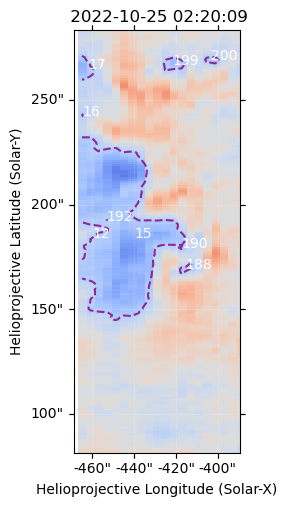

In [5]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1024)
eis_195_velmap_shift_1024.plot(axes=ax)

cs_eis_1024 = eis_195_velmap_shift_1024.draw_contours(levels=[-5,],colors=["purple"],axes=ax,alpha=0.8)

ax.set_xlim(0,20)
ax.set_ylim(150,350)

for ii, seg in enumerate(cs_eis_1024.allsegs[0]):
    if np.nanmean(seg, axis=0)[0] > 0 and np.nanmean(seg, axis=0)[0] < 20 and \
        np.nanmean(seg, axis=0)[1] > 150 and np.nanmean(seg, axis=0)[1] < 350:
        ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)


plt.subplots_adjust(bottom=0.0)

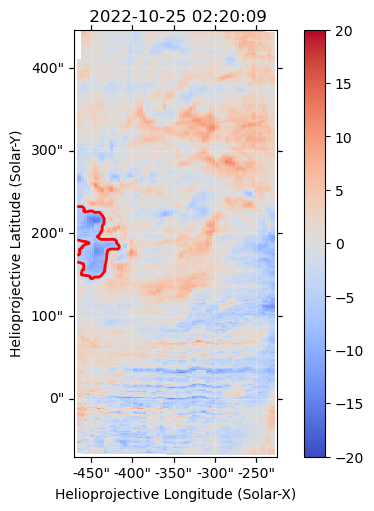

In [6]:
cs_selected_index_1024 = [12,15]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1024)
eis_195_velmap_shift_1024.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1024:
    ax.plot(*cs_eis_1024.allsegs[0][ii].T, color='red', lw=2)

In [7]:
cs_skycoords_eis_1024 = [eis_195_velmap_shift_1024.pixel_to_world(np.concatenate((cs_eis_1024.allsegs[0][cs_selected_index_1024[0]][:,0],
                                                                    cs_eis_1024.allsegs[0][cs_selected_index_1024[1]][:,0]))*u.pix,
                                                    np.concatenate((cs_eis_1024.allsegs[0][cs_selected_index_1024[0]][:,1],
                                                                    cs_eis_1024.allsegs[0][cs_selected_index_1024[1]][:,1]))*u.pix) \
                ]
cs_regions_eis_1024 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_eis_1024]

In [8]:
cs_regions_eis_1024[0].to_pixel(eis_195_velmap_shift_1024.wcs).write('../../sav/regions/eis_1024_east_pixel.reg',overwrite=True)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


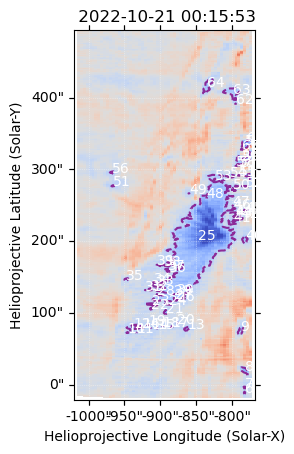

In [9]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1020)
eis_195_velmap_shift_1020.plot(axes=ax)

cs_eis_1020 = eis_195_velmap_shift_1020.draw_contours(levels=[-5,],colors=["purple"],axes=ax,alpha=0.8)


for ii, seg in enumerate(cs_eis_1020.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

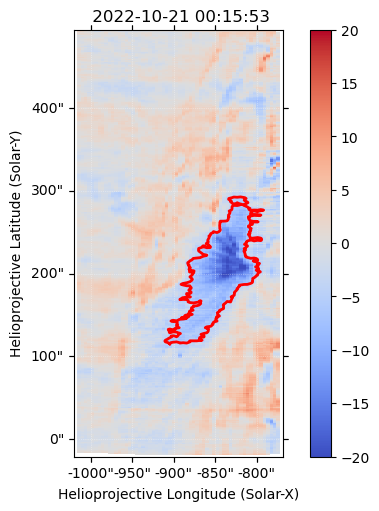

In [10]:
cs_selected_index_1020 = [25]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1020)
eis_195_velmap_shift_1020.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1020:
    ax.plot(*cs_eis_1020.allsegs[0][ii].T, color='red', lw=2)

In [11]:
cs_skycoords_eis_1020 = [eis_195_velmap_shift_1020.pixel_to_world(cs_eis_1020.allsegs[0][cs_selected_index_1020[0]][:,0]*u.pix,
                                                    cs_eis_1020.allsegs[0][cs_selected_index_1020[0]][:,1]*u.pix) \
                ]
cs_regions_eis_1020 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_eis_1020]

In [12]:
cs_regions_eis_1020[0].to_pixel(eis_195_velmap_shift_1020.wcs).write('../../sav/regions/eis_1020_west_pixel.reg',overwrite=True)

In [13]:
eis_195_intmap_shift_1024_crop = eis_195_intmap_shift_1024.submap(SkyCoord(eis_195_intmap_shift_1024.bottom_left_coord.Tx,
                                                                           100*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame),
                                                                  top_right=SkyCoord(eis_195_intmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame))
eis_195_intmap_shift_1024_crop.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 1),
                                                                      vmax=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 99),
                                                                      stretch=AsinhStretch())

eis_195_velmap_shift_1024_crop = eis_195_velmap_shift_1024.submap(SkyCoord(eis_195_velmap_shift_1024.bottom_left_coord.Tx,
                                                                            100*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame),
                                                                    top_right=SkyCoord(eis_195_velmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame))

eis_195_intmap_shift_1020_crop = eis_195_intmap_shift_1020.submap(SkyCoord(eis_195_intmap_shift_1020.bottom_left_coord.Tx,
                                                                                100*u.arcsec, frame=eis_195_intmap_shift_1020.coordinate_frame),
                                                                        top_right=SkyCoord(eis_195_intmap_shift_1020.top_right_coord.Tx,
                                                                                 400*u.arcsec, frame=eis_195_intmap_shift_1020.coordinate_frame))
eis_195_intmap_shift_1020_crop.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_195_intmap_shift_1020_crop.data, 1),
                                                                      vmax=np.nanpercentile(eis_195_intmap_shift_1020_crop.data, 99),
                                                                      stretch=AsinhStretch())

eis_195_velmap_shift_1020_crop = eis_195_velmap_shift_1020.submap(SkyCoord(eis_195_velmap_shift_1020.bottom_left_coord.Tx,
                                                                                100*u.arcsec, frame=eis_195_velmap_shift_1020.coordinate_frame),
                                                                        top_right=SkyCoord(eis_195_velmap_shift_1020.top_right_coord.Tx,
                                                                                400*u.arcsec, frame=eis_195_velmap_shift_1020.coordinate_frame))

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


In [14]:
spice_hri_NeVIII_intmap_1024 = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_intmap_derot_repro_hrifov.fits")
spice_hri_NeVIII_intmap_1024 = sunpy.map.Map(spice_hri_NeVIII_intmap_1024.data*1e3, spice_hri_NeVIII_intmap_1024.meta) # W/m^2 -> erg/cm^2/s
spice_hri_NeVIII_velmap_1024 = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_velmap_derot_repro_hrifov.fits")
spice_hri_NeVIII_intmap_1024 = spice_hri_NeVIII_intmap_1024.submap([300,20]*u.pix, top_right=[1750, 1300]*u.pix)
spice_hri_NeVIII_velmap_1024 = spice_hri_NeVIII_velmap_1024.submap([300,20]*u.pix, top_right=[1750, 1300]*u.pix)
spice_hri_NeVIII_intmap_1024.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(spice_hri_NeVIII_intmap_1024.data, 0.3),
                                                                    vmax=np.nanpercentile(spice_hri_NeVIII_intmap_1024.data, 99.7),
                                                                    stretch=AsinhStretch())
spice_hri_NeVIII_intmap_1024.plot_settings['cmap'] = 'sdoaia171'
spice_hri_NeVIII_intmap_1024.plot_settings['aspect'] = spice_hri_NeVIII_intmap_1024.scale.axis2/spice_hri_NeVIII_intmap_1024.scale.axis1
spice_hri_NeVIII_velmap_1024.plot_settings['norm'] = ImageNormalize(vmin=-30,vmax=30)
spice_hri_NeVIII_velmap_1024.plot_settings['cmap'] = 'coolwarm'

In [15]:
spice_1024_cube = read_spice_l2_fits('../../src/SPICE/20221024/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000_coalign.fits')
spice_1024_window_example = spice_1024_cube['Ne VIII 770 - Peak']

Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


In [16]:
spice_NeVIII_intmap_1017 = sunpy.map.Map("../../src/coalign_map/20221017/spice_NeVIII_intmap_derot.fits")
spice_NeVIII_intmap_1017 = sunpy.map.Map(spice_NeVIII_intmap_1017.data*1e3, spice_NeVIII_intmap_1017.meta) # W/m^2 -> erg/cm^2/s
spice_NeVIII_velmap_1017 = sunpy.map.Map("../../src/coalign_map/20221017/spice_NeVIII_velmap_derot.fits")
spice_NeVIII_intmap_1017 = spice_NeVIII_intmap_1017.submap([25,0]*u.pix, top_right=[spice_NeVIII_velmap_1017.data.shape[1], spice_NeVIII_velmap_1017.data.shape[0]]*u.pix)
spice_NeVIII_velmap_1017 = spice_NeVIII_velmap_1017.submap([25,0]*u.pix, top_right=[spice_NeVIII_velmap_1017.data.shape[1], spice_NeVIII_velmap_1017.data.shape[0]]*u.pix)
spice_NeVIII_intmap_1017.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(spice_NeVIII_intmap_1017.data, 0.3),
                                                                    vmax=np.nanpercentile(spice_NeVIII_intmap_1017.data, 99.7),
                                                                    stretch=AsinhStretch())
spice_NeVIII_intmap_1017.plot_settings['cmap'] = 'sdoaia171'
spice_NeVIII_intmap_1017.plot_settings['aspect'] = spice_NeVIII_intmap_1017.scale.axis2/spice_NeVIII_intmap_1017.scale.axis1
spice_NeVIII_velmap_1017.plot_settings['norm'] = ImageNormalize(vmin=-30,vmax=30)
spice_NeVIII_velmap_1017.plot_settings['cmap'] = 'coolwarm'
spice_NeVIII_velmap_1017.plot_settings['aspect'] = spice_NeVIII_velmap_1017.scale.axis2/spice_NeVIII_velmap_1017.scale.axis1

In [17]:
spice_1017_cube = read_spice_l2_fits('../../src/SPICE/20221016/solo_L2_spice-n-ras_20221017T031211_V03_150995346-000_coalign.fits')
spice_1017_window_example = spice_1017_cube['Ne VIII 770 / Mg VIII 772 (Merged)']

Set MJD-OBS to 59869.133468 from DATE-OBS.
Set MJD-BEG to 59869.133468 from DATE-BEG.
Set MJD-AVG to 59869.211569 from DATE-AVG.
Set MJD-END to 59869.289669 from DATE-END'. [astropy.wcs.wcs]


In [18]:
def get_ax_size(ax, return_ratio=True):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    if return_ratio:
        return height/width
    else:
        return width, height

<a id='figure-3'></a>
### Figure 3
(You may have to pull down to see the notebook preview of the figure)

[back to top](#notebook-top) 

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


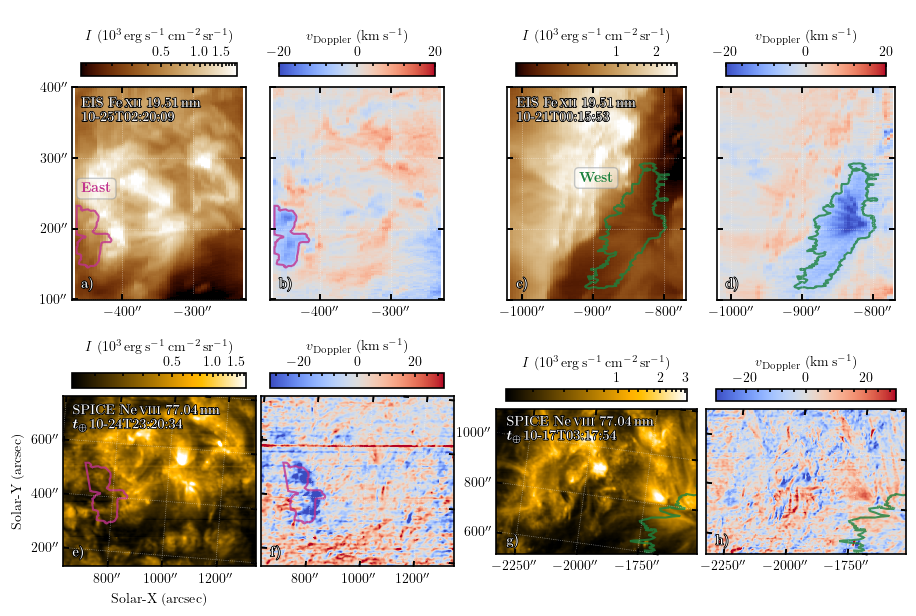

In [19]:
with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(9,6),layout='constrained')

    gs_width_ratio_optimal = (eis_195_intmap_shift_1024_crop.top_right_coord.Ty - eis_195_intmap_shift_1024_crop.bottom_left_coord.Ty) / \
                            (eis_195_intmap_shift_1024_crop.top_right_coord.Tx - eis_195_intmap_shift_1024_crop.bottom_left_coord.Tx) * \
                            (eis_195_intmap_shift_1020_crop.top_right_coord.Tx - eis_195_intmap_shift_1020_crop.bottom_left_coord.Tx) / \
                            (eis_195_intmap_shift_1020_crop.top_right_coord.Ty - eis_195_intmap_shift_1020_crop.bottom_left_coord.Ty)

    gs1 = fig.add_gridspec(2, 4, figure=fig, height_ratios=[1,0.8],
                        width_ratios=[1,1,gs_width_ratio_optimal,gs_width_ratio_optimal],
                        hspace=0.01)

    ax1 = fig.add_subplot(gs1[0,0], projection=eis_195_intmap_shift_1024_crop)
    im1 = eis_195_intmap_shift_1024_crop.plot(axes=ax1, title=None)
    cs_regions_eis_1024[0].to_pixel(eis_195_intmap_shift_1024_crop.wcs).plot(ax=ax1, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb1, clb_ax1 = plot_colorbar(im1, ax1, 
                                  bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                  fontsize=10,scilimits=(0,0))
    fig.canvas.draw_idle()
    clb1.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax1.xaxis.get_offset_text().get_text()).group(1)))
    
    ax1.text(0.05, 0.04, r'\textbf{a)}', transform=ax1.transAxes, fontsize=10, va='bottom',
             ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                path_effects.Normal()])
    
    ax1.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}' 
                         "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1024_crop.date.isot[5:-4]),
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
             color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                          path_effects.Normal()])
    
    ax1.text(0.05, 0.55, r"\textbf{East}", transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             color='#C1328E',bbox=dict(boxstyle="round", fc="w", ec="#91989F",alpha=0.5))

    ax2 = fig.add_subplot(gs1[0,1], projection=eis_195_velmap_shift_1024_crop)
    im2 = eis_195_velmap_shift_1024_crop.plot(axes=ax2, title=None)
    cs_regions_eis_1024[0].to_pixel(eis_195_velmap_shift_1024_crop.wcs).plot(ax=ax2, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb2, clb_ax2 = plot_colorbar(im2, ax2,
                                    bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax2.text(0.05, 0.04, r'\textbf{b)}', transform=ax2.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])

    ax3 = fig.add_subplot(gs1[0,2], projection=eis_195_intmap_shift_1020_crop)
    im3 = eis_195_intmap_shift_1020_crop.plot(axes=ax3, title=None)
    cs_regions_eis_1020[0].to_pixel(eis_195_intmap_shift_1020_crop.wcs).plot(ax=ax3, edgecolor='#1B813E', lw=1.5,alpha=0.8)

    clb3, clb_ax3 = plot_colorbar(im3, ax3,
                                    bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    fig.canvas.draw_idle()
    clb3.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax3.xaxis.get_offset_text().get_text()).group(1)))
    
    ax3.text(0.05, 0.04, r'\textbf{c)}', transform=ax3.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax3.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}'
                            "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1020_crop.date.isot[5:-4]),
                transform=ax3.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
                color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                            path_effects.Normal()])
    ax3.text(0.4, 0.6, r"\textbf{West}", transform=ax3.transAxes, fontsize=10, va='top', ha='left',
             color='#1B813E',bbox=dict(boxstyle="round", fc="w", ec="#91989F",alpha=0.5))

    ax4 = fig.add_subplot(gs1[0,3], projection=eis_195_velmap_shift_1020_crop)
    im4 = eis_195_velmap_shift_1020_crop.plot(axes=ax4, title=None)
    cs_regions_eis_1020[0].to_pixel(eis_195_velmap_shift_1020_crop.wcs).plot(ax=ax4, edgecolor='#1B813E', lw=1.5,alpha=0.8)

    clb4, clb_ax4 = plot_colorbar(im4, ax4,
                                    bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax4.text(0.05, 0.04, r'\textbf{d)}', transform=ax4.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax5 = fig.add_subplot(gs1[1,0], projection=spice_hri_NeVIII_intmap_1024)
    im5 = spice_hri_NeVIII_intmap_1024.plot(axes=ax5,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1024[0].to_pixel(spice_hri_NeVIII_intmap_1024.wcs).plot(ax=ax5, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    ax5.set_xlabel(r'Solar-X (arcsec)')
    ax5.set_ylabel(r'Solar-Y (arcsec)')

    fig.canvas.draw_idle()

    clb5_bbox_height = 0.06*get_ax_size(ax1)/get_ax_size(ax5)

    clb5, clb_ax5 = plot_colorbar(im5, ax5,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    
    clb5.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax1.xaxis.get_offset_text().get_text()).group(1)))
    
    ax5.text(0.05, 0.04, r'\textbf{e)}', transform=ax5.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax5.text(0.05, 0.95, r'\textbf{SPICE Ne\,\textsc{viii} 77.04\,nm}'
                            "\n" + r'$\boldsymbol{{t_\oplus}}\,$\textbf{{{}}}'.format(spice_1024_window_example.meta['DATE_EAR'][5:-4]),
            transform=ax5.transAxes,
            va='top', ha='left', fontsize=10, color='white', linespacing=1.2, 
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                          path_effects.Normal()])

    # ax5.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}' 
    #                      "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1024_crop.date.isot[5:-4]),
    #          transform=ax5.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
    #          color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
    #                                       path_effects.Normal()])

    ax6 = fig.add_subplot(gs1[1,1], projection=spice_hri_NeVIII_velmap_1024)
    im6 = spice_hri_NeVIII_velmap_1024.plot(axes=ax6,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1024[0].to_pixel(spice_hri_NeVIII_velmap_1024.wcs).plot(ax=ax6, edgecolor='#C1328E', lw=1.5,alpha=0.8)
    
    clb6, clb_ax6 = plot_colorbar(im6, ax6,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax6.text(0.05, 0.04, r'\textbf{f)}', transform=ax6.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax7 = fig.add_subplot(gs1[1,2], projection=spice_NeVIII_intmap_1017)
    im7 = spice_NeVIII_intmap_1017.plot(axes=ax7,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1020[0].to_pixel(spice_NeVIII_intmap_1017.wcs).plot(ax=ax7, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    
    clb7, clb_ax7 = plot_colorbar(im7, ax7,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    
    fig.canvas.draw_idle()
    
    clb7.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax7.xaxis.get_offset_text().get_text()).group(1)))
    
    ax7.text(0.05, 0.04, r'\textbf{g)}', transform=ax7.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax7.text(0.05, 0.95, r'\textbf{SPICE Ne\,\textsc{viii} 77.04\,nm}'
                            "\n" + r'$\boldsymbol{{t_\oplus}}\,$\textbf{{{}}}'.format(spice_1017_window_example.meta['DATE_EAR'][5:-4]),
            transform=ax7.transAxes,
            va='top', ha='left', fontsize=10, color='white', linespacing=1.2,
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                          path_effects.Normal()])
    
    ax8 = fig.add_subplot(gs1[1,3], projection=spice_NeVIII_velmap_1017)
    im8 = spice_NeVIII_velmap_1017.plot(axes=ax8,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1020[0].to_pixel(spice_NeVIII_velmap_1017.wcs).plot(ax=ax8, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    
    clb8, clb_ax8 = plot_colorbar(im8, ax8,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax8.text(0.05, 0.04, r'\textbf{h)}', transform=ax8.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])

    for ax_ in (ax1,ax2,ax3,ax4,ax6,):
        ax_.set_title(' ')
        ax_.coords[0].axislabels.set_visible(False)
        ax_.coords[1].axislabels.set_visible(False)
        ax_.coords[0].set_ticks(number=3)
        ax_.coords[1].set_ticks(number=3)
    
    ax7.coords[0].axislabels.set_visible(False)
    ax7.coords[1].axislabels.set_visible(False)
    ax7.coords[1].set_ticks(number=3)
    ax7.coords[0].set_ticks(spacing=250*u.arcsec)
    ax7.coords[0].set_major_formatter('s')

    ax8.coords[0].axislabels.set_visible(False)
    ax8.coords[1].axislabels.set_visible(False)
    ax8.coords[1].set_ticks(number=3)
    ax8.coords[0].set_ticks(spacing=250*u.arcsec)
    ax8.coords[0].set_major_formatter('s')

    for clb_ax_ in (clb_ax1,clb_ax2, clb_ax3, clb_ax4, clb_ax5, clb_ax6, clb_ax7, clb_ax8):
        clb_ax_.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                            length=3)
        clb_ax_.xaxis.tick_top()
        clb_ax_.xaxis.set_label_position('top') 
        offset_text = clb_ax_.xaxis.get_offset_text()
        if offset_text is not None:
            offset_text.set_visible(False)
            # offset_text_pos = offset_text.get_position()
            # offset_text.set_position((offset_text_pos[0]+0.17, offset_text_pos[1]))
            # clb_ax_.xaxis.OFFSETTEXTPAD = -9

    for ax_ in (ax2,ax3,ax4,ax6,ax8):
        ax_.coords[1].set_ticklabel_visible(False)

    # in maptlotlib 3.9 the rasterization of colorbar will be misplaced in PDF 
    # backend by setting `bbox_inches='tight'` with `inset_axes` from 
    #`mpl_toolkits.axes_grid1.inset_locator` module
    # see github issues:
    # https://github.com/matplotlib/matplotlib/issues/28549
    # https://github.com/matplotlib/matplotlib/issues/27763

    fig.get_layout_engine().set(w_pad=1/72., h_pad=1/72., hspace=0,
                        wspace=0)
    
    plt.savefig('../../figs/ms_eis_eui_upflow/eis_spice_doppler.pdf', dpi=300, bbox_inches='tight')
    plt.show()

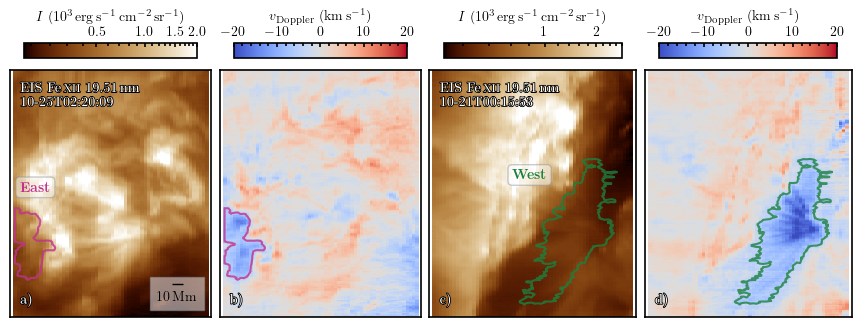

In [20]:
from fancy_colorbar import wcs_scalebar
with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(8.5,4),layout='constrained')
    gs = fig.add_gridspec(1, 4, figure=fig,
                        width_ratios=[1,1,gs_width_ratio_optimal,gs_width_ratio_optimal],
                        hspace=0.01)

    ax1 = fig.add_subplot(gs[0], projection=eis_195_intmap_shift_1024_crop)
    ax2 = fig.add_subplot(gs[1], projection=eis_195_velmap_shift_1024_crop)
    ax3 = fig.add_subplot(gs[2], projection=eis_195_intmap_shift_1020_crop)
    ax4 = fig.add_subplot(gs[3], projection=eis_195_velmap_shift_1020_crop)

    im1 = eis_195_intmap_shift_1024_crop.plot(axes=ax1, norm=ImageNormalize(vmax=2e3, stretch=AsinhStretch(0.2)),
                                              title=None)
    cs_regions_eis_1024[0].to_pixel(eis_195_intmap_shift_1024_crop.wcs).plot(ax=ax1, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb1, clb_ax1 = plot_colorbar(im1, ax1,
                                    bbox_to_anchor=(0.07,1.05,0.86,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    fig.canvas.draw_idle()
    clb1.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax1.xaxis.get_offset_text().get_text()).group(1)))
    
    ax1.text(0.05, 0.04, r'\textbf{a)}', transform=ax1.transAxes, fontsize=10, va='bottom',
             ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                path_effects.Normal()])
    
    ax1.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}' 
                         "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1024_crop.date.isot[5:-4]),
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
             color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                          path_effects.Normal()])
    
    ax1.text(0.05, 0.55, r"\textbf{East}", transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             color='#C1328E',bbox=dict(boxstyle="round", fc="w", ec="#91989F",alpha=0.5))

                                                                                    

    im2 = eis_195_velmap_shift_1024_crop.plot(axes=ax2, norm=ImageNormalize(vmin=-20,vmax=20),
                                              title=None,)

    cs_regions_eis_1024[0].to_pixel(eis_195_velmap_shift_1024_crop.wcs).plot(ax=ax2, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb2, clb_ax2 = plot_colorbar(im2, ax2,
                                    bbox_to_anchor=(0.07,1.05,0.86,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax2.text(0.05, 0.04, r'\textbf{b)}', transform=ax2.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    im3 = eis_195_intmap_shift_1020_crop.plot(axes=ax3, norm=ImageNormalize(vmax=2.8e3, stretch=AsinhStretch(0.2)),
                                                title=None)
    
    cs_regions_eis_1020[0].to_pixel(eis_195_intmap_shift_1020_crop.wcs).plot(ax=ax3, edgecolor='#1B813E', lw=1.5,alpha=0.8)

    clb3, clb_ax3 = plot_colorbar(im3, ax3,
                                    bbox_to_anchor=(0.07,1.05,0.86,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    fig.canvas.draw_idle()
    clb3.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax3.xaxis.get_offset_text().get_text()).group(1)))

    ax3.text(0.05, 0.04, r'\textbf{c)}', transform=ax3.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax3.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}'
                            "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1020_crop.date.isot[5:-4]),
                transform=ax3.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
                color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                            path_effects.Normal()])
    ax3.text(0.4, 0.6, r"\textbf{West}", transform=ax3.transAxes, fontsize=10, va='top', ha='left',
             color='#1B813E',bbox=dict(boxstyle="round", fc="w", ec="#91989F",alpha=0.5))
    
    im4 = eis_195_velmap_shift_1020_crop.plot(axes=ax4, norm=ImageNormalize(vmin=-20,vmax=20),
                                                title=None)
    
    cs_regions_eis_1020[0].to_pixel(eis_195_velmap_shift_1020_crop.wcs).plot(ax=ax4, edgecolor='#1B813E', lw=1.5,alpha=0.8)

    clb4, clb_ax4 = plot_colorbar(im4, ax4,
                                    bbox_to_anchor=(0.07,1.05,0.86,0.06), orientation='horizontal',  
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax4.text(0.05, 0.04, r'\textbf{d)}', transform=ax4.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),
                                                    path_effects.Normal()]) 

    # for ax_ in (ax1,ax2,ax4):
    #     ax_.coords[0].axislabels.set_visible(False)
    #     ax_.coords[1].axislabels.set_visible(False)
    # for ax_ in (ax1,ax2,ax3,ax4):
    #     ax_.coords[0].set_ticks(number=3)
    #     ax_.coords[1].set_ticks(number=3)
    


    for clb_ax_ in (clb_ax1,clb_ax2,clb_ax3,clb_ax4):
        clb_ax_.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                            length=3)
        clb_ax_.xaxis.tick_top()
        clb_ax_.xaxis.set_label_position('top') 
        offset_text = clb_ax_.xaxis.get_offset_text()
        if offset_text is not None:
            offset_text.set_visible(False)
            # offset_text_pos = offset_text.get_position()
            # offset_text.set_position((offset_text_pos[0]+0.17, offset_text_pos[1]))
            # clb_ax_.xaxis.OFFSETTEXTPAD = -9

    # for ax_ in (ax2,ax3,ax4,):
    #     ax_.coords[1].set_ticklabel_visible(False)
    
    # for ax_ in (ax1,ax2):
    #     ax_.coords[0].set_ticklabel_visible(False)
    
    # ax1.set_xlabel(r'Solar-X (arcsec)')
    # ax1.set_ylabel(r'Solar-Y (arcsec)')

    for ax_ in (ax1,ax2,ax3,ax4):
        for coord_index in (0,1):
            coord = ax_.coords[coord_index]
            coord.set_ticks_visible(False)
            coord.set_ticklabel_visible(False)
            coord.set_axislabel('')
            coord.axislabels.set_visible(False)
            coord.grid(draw_grid=False) 
        # ax_.axis("off")

    wcs_scalebar(ax1, length=10*u.Mm, color='black', label=r'10\,Mm', corner='bottom right', borderpad=0.5,
                    frame=True,bbox_props=dict(boxstyle='round,pad=0',facecolor='white', edgecolor='#91989F', alpha=0.5))

    fig.savefig("../../figs/test_figs/eis_spice_doppler_karbacher.png", dpi=300, bbox_inches='tight')

    plt.show()